#### Segmentation of Brain Hemorrhages

Importing the required packages

In [114]:
import keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
assert tf.__version__ >= "2.0"
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks
import pandas as pd
import cv2
import matplotlib
from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
import tensorflow_datasets as tfds

import sys
import glob
import random

import zipfile

from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import json
import re

import pylab as plt
import numpy as np
from matplotlib.path import Path

import numpy
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split

from PIL import Image
import cv2 as cv

Reading the csvs with segmentation labels

In [115]:
file_dir = 'Project\\'
#Reading the segmentation csvs
epidural_labels = pd.read_csv(file_dir + 'Results_Epidural.csv',index_col=None)
ip_labels = pd.read_csv(file_dir + 'Results_Intraparenchymal.csv',index_col=None)
subd_labels = pd.read_csv(file_dir + 'Results_Subdural.csv',index_col=None)
suba_labels = pd.read_csv(file_dir + 'Results_Subarachnoid.csv',index_col=None)
multi_labels = pd.read_csv(file_dir + 'Results_Multiple.csv',index_col=None)

Creating a Segmentation Label column with Correct Labels which if not available will be filled with Majority Labels

In [116]:
epidural_labels['Segmentation Label'] = epidural_labels['Correct Label'].fillna(epidural_labels['Majority Label'])
ip_labels['Segmentation Label'] = ip_labels['Correct Label'].fillna(ip_labels['Majority Label'])
subd_labels['Segmentation Label'] = subd_labels['Correct Label'].fillna(subd_labels['Majority Label'])
suba_labels['Segmentation Label'] = suba_labels['Correct Label'].fillna(suba_labels['Majority Label'])
multi_labels['Segmentation Label'] = multi_labels['Correct Label'].fillna(multi_labels['Majority Label'])

#### Creating segmentation masks

Function to create segmentation masks using the labels provided

In [117]:
def get_mask(test_str):
    split = test_str.split(']')
    masks = []
    for roi in split:
        roi = str.replace(roi, "[", "").lstrip(" ,")
        # print("Cleaned: ", roi)
        if roi != "":
            roi = "{\"points\": [" + roi + "]}"
            roi = str.replace(roi, "'", '"')
            roi_json = json.loads(roi)
            points = []
            for point in roi_json['points']:
                points.append((point['x']*512, point['y']*512))
            masks.append(points)

    return masks

def poly_mask(shape, vertices, value=np.nan):
    width, height = shape[::-1]
    # create a binary image
    img = Image.new(mode='L', size=(width, height), color=0)  # mode L = 8-bit pixels, black and white
    draw = ImageDraw.Draw(img)
    # draw polygons
    for polygon in vertices:
        draw.polygon(polygon, outline=1, fill=1)
    # replace 0 with 'value'
    #mask = np.array(img).astype('float32')
    #mask[np.where(mask == 0)] = value
    return img


#### Using Epidural Hemorrhage Type for Segmentation

In [118]:
shape = [512,512]
filedir = 'C:\\Users\\thari\\Downloads\\XN_Project\\renders\\masks\\epidural\\'
for n,filename in  enumerate(epidural_labels.Origin):
    polygon = get_mask(epidural_labels.loc[n]['Segmentation Label'])
    #if len(polygon) > 0:
        #plt.figure(figsize=(5.12, 5.12), dpi=100)
    img = poly_mask(shape, polygon, value=0)
        #plt.imshow(mask.reshape(512, 512))
        #plt.savefig(filedir+filename[:-4]+".png",dpi=100)
    img.save(filedir+filename[:-4]+".png")
#     else:
#         polygon1 = [[(0,0),(0,0)]]
#         plt.figure(figsize=(5.12, 5.12), dpi=100)
#         mask = poly_mask(shape, polygon1, value=0)
#         plt.imshow(mask.reshape(512, 512))
#         plt.savefig(filedir+filename[:-4]+".png",dpi=100)

In [133]:
image_path = "Project\\renders\\epidural\\brain_window"
mask_path = "Project\\renders\\masks\\epidural\\"

In [134]:
mask_list = os.listdir(mask_path)
mask_list = [x[:-4] for x in mask_list]

In [135]:
image_list = [i for i in sorted(os.listdir(image_path)) if os.path.splitext(i)[0] in mask_list]
mask_list = [m for m in sorted(os.listdir(mask_path)) if os.path.splitext(m)[0] in mask_list]

image_list = [image_path+'\\'+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [136]:
df = pd.DataFrame({'images':image_list, 'masks':mask_list})
img_train, img_test, mask_train, mask_test = train_test_split(df['images'], df['masks'], test_size=0.15, random_state=7)
img_val, img_test, mask_val, mask_test = train_test_split(img_test, mask_test, test_size=0.3, random_state=7)
print(len(img_train), len(img_val), len(img_test))

425 52 23


#### Sample Image and Mask Visualization

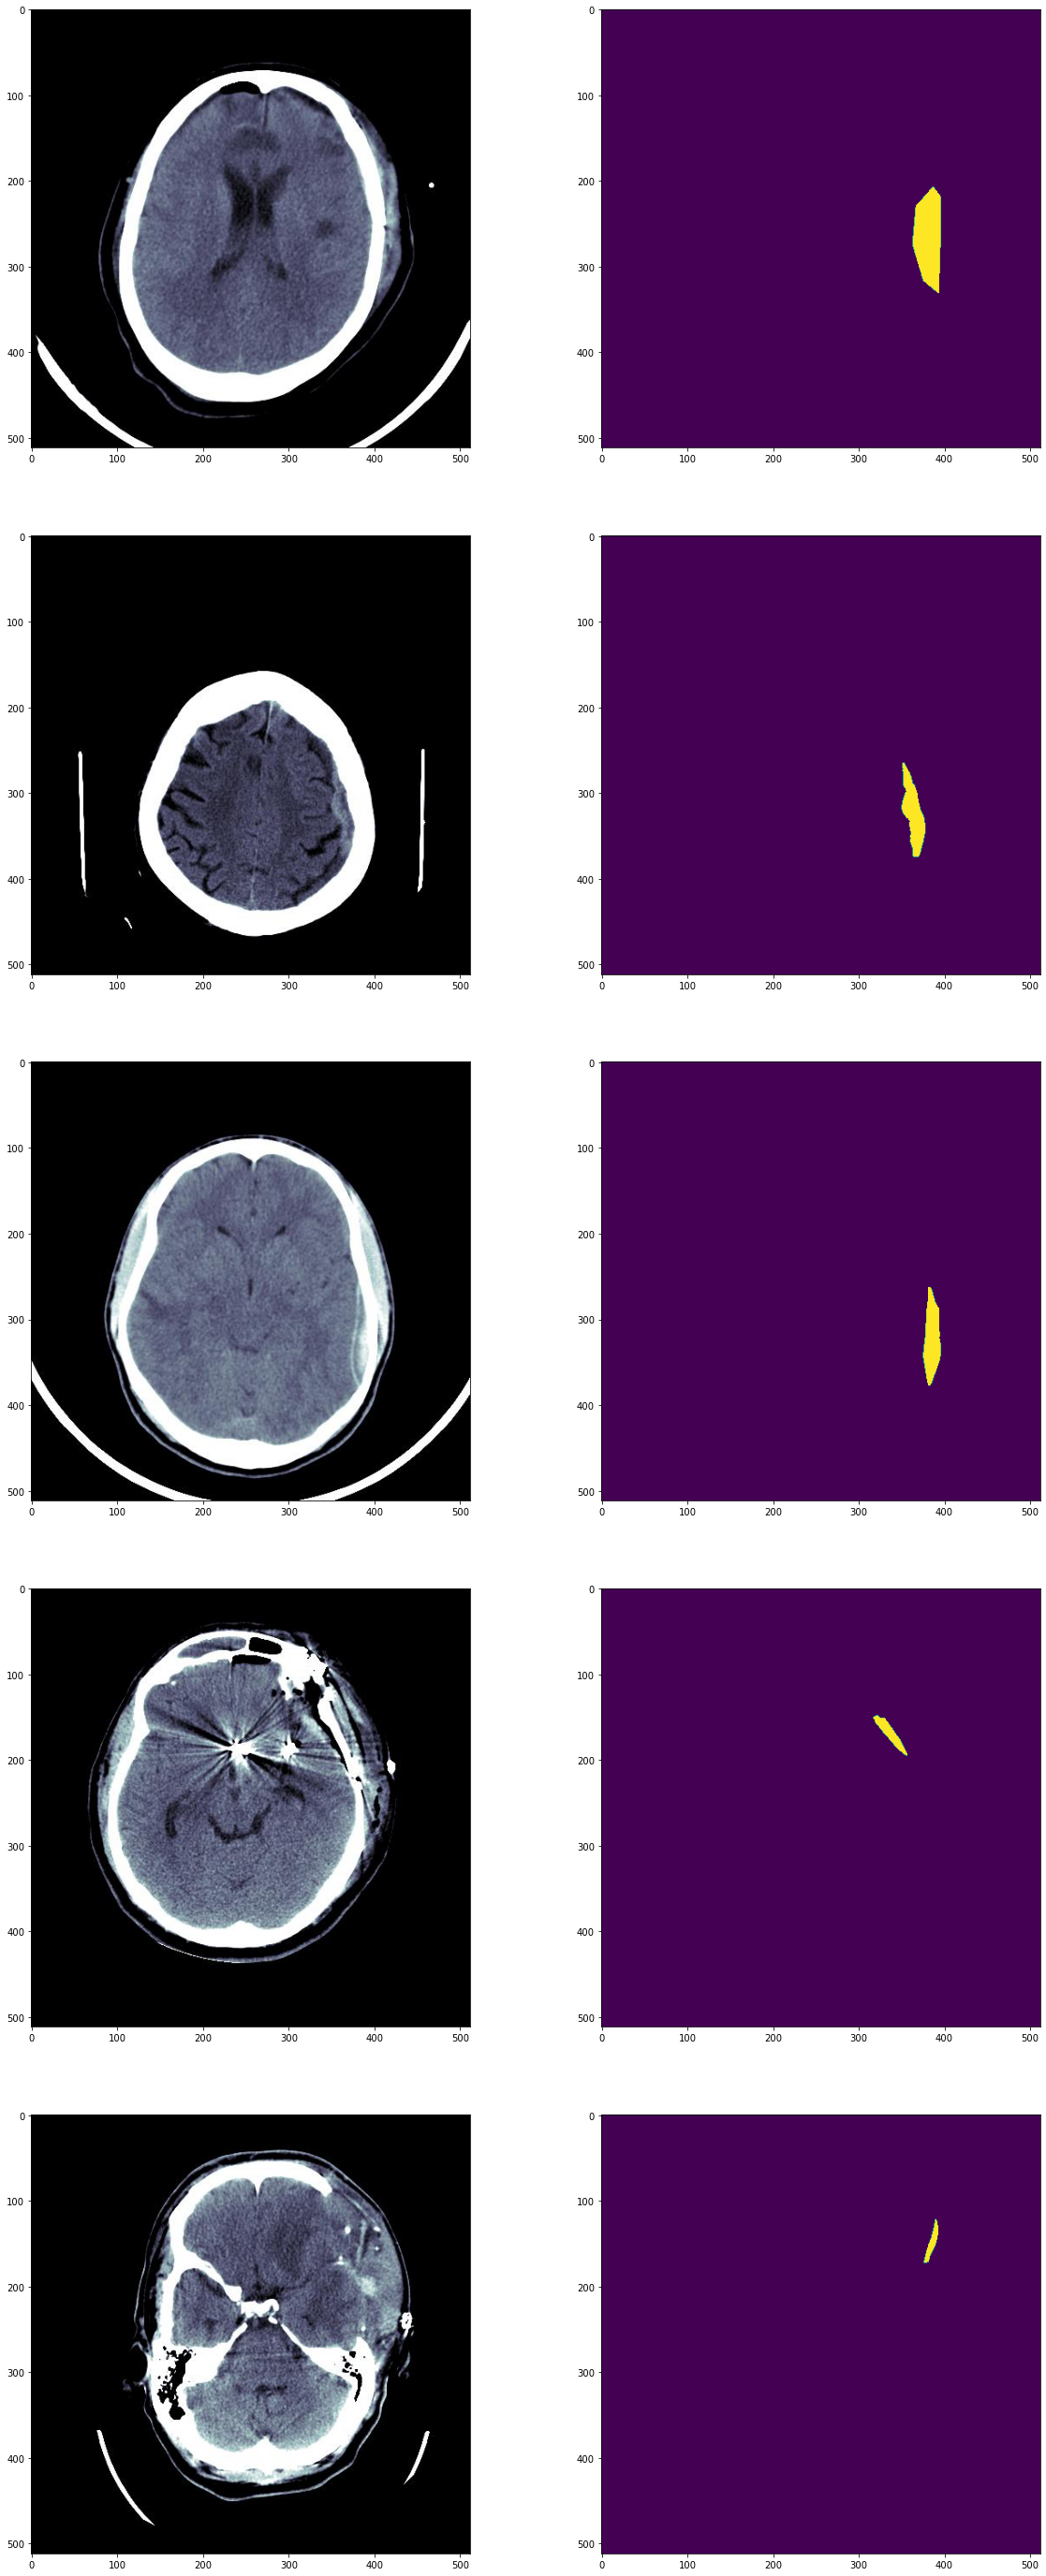

In [138]:
def visualize_img_mask(img_train, mask_train, k = 3):
    N = img_train.shape[0]
    fig, ax = plt.subplots(k, 2, figsize=(20,10*k))
    for i,l in enumerate(random.sample(range(N), k)):
        img = img_train.iloc[l]
        mask = mask_train.iloc[l]
        ax[i,0].imshow(Image.open(img))
        # ax[i,1].imshow(Image.open(mask))
        ax[i,1].imshow(cv.imread(mask, cv.IMREAD_GRAYSCALE))
        
visualize_img_mask(img_train, mask_train, k=5)


In [124]:
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG16

from warnings import filterwarnings
filterwarnings('ignore')

import random

np.random.seed(7)
tf.random.set_seed(7)

Defining a function for model loss

In [125]:
def weighted_categorical_crossentropy(weights):
    # weights = [0.9,0.05,0.04,0.01]
    def wcce(y_true, y_pred):
        Kweights = K.constant(weights)
        # if not K.is_tensor(y_pred): y_pred = K.constant(y_pred)
        y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    return wcce

model_loss = weighted_categorical_crossentropy([0.01, 0.99])

#### U-Net with VGG-16 for Encoders

In [143]:
n_classes = 2
H = 512    
W = H*6//4   # to keep the H:W ratio equal to 4000:6000 <- the original ratio

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """    
    s1 = vgg16.get_layer("block1_conv2").output         
    s2 = vgg16.get_layer("block2_conv2").output         
    s3 = vgg16.get_layer("block3_conv3").output         
    s4 = vgg16.get_layer("block4_conv3").output         

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(n_classes, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    model.compile(loss=model_loss, optimizer='adam', metrics=['accuracy'])
    return model

model = build_vgg16_unet((H,W,3))
# Retrieve the config
config = model.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
## https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
custom_objects = {"model_loss": model_loss}
with keras.utils.custom_object_scope(custom_objects):
    model = keras.Model.from_config(config)
model.compile(loss=model_loss, optimizer='adam', metrics=['accuracy'])

Functions for image pre-processing

In [144]:
def read_image(x):
    x = cv.imread(x, cv.IMREAD_COLOR)
    x = cv.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv.imread(x, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, n_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, n_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

In [145]:
segmentation_path = "Project\\renders\\"
epidural_model_segmentation = segmentation_path + "epidural_model_segmentation.h5"
checkpointer = [
    ModelCheckpoint(filepath= epidural_model_segmentation, monitor='val_loss',verbose=2,save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=3, verbose=2, min_delta=1e-4)
]

batch_size = 4
train_dataset = tf_dataset(img_train, mask_train, batch=batch_size)
val_dataset = tf_dataset(img_val, mask_val, batch=batch_size)

train_steps = len(img_train)//batch_size
val_steps = len(img_val)//batch_size

Running the model for 5 epochs

In [ ]:
EPOCHS = 5
#VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
epidural_model_segmentation = segmentation_path + "epidural_model_segmentation1.h5"
checkpointer = [
    ModelCheckpoint(filepath= epidural_model_segmentation, monitor='val_loss',verbose=2,save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=3, verbose=2, min_delta=1e-4)
]

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=train_steps,
                          validation_steps=val_steps,
                          validation_data=val_dataset,
                          callbacks=checkpointer)

#### Visualizing the Predictions

In [ ]:
def visualize_predictions(img_test, mask_test, k = 3):
    N = img_test.shape[0]
    fig, ax = plt.subplots(k, 3, figsize=(7*3, 5*k))
    for i,l in enumerate(random.sample(range(N), k)):
        x = read_image(img_test.iloc[l])
        y = read_mask(mask_test.iloc[l])
        p = model.predict(x[np.newaxis, ...])[0]
        p = np.argmax(p, axis=-1)
        ax[i,0].imshow(x)
        ax[i,0].set_title('image')
        ax[i,1].imshow(y)
        ax[i,1].set_title('ground-truth mask')
        ax[i,2].imshow(p)
        ax[i,2].set_title('predicted mask')
        
visualize_predictions(img_test, mask_test, k=3)